# Detector with Energy Function on CIFAR-10

In [1]:
# INSTALL LIBRARY FOR G-CNNS
! pip install numpy scipy matplotlib nose
! pip install ipywidgets

! pip install torchattacks
! pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch
import numpy as np
import sklearn
import scipy
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from typing import *
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torch.nn import functional as F
from torch.nn import Conv2d
from torch.nn import MaxPool2d as MaxPool2d
from tqdm import tqdm
import torchvision.models as models
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

# Reproducibility stuff

In [3]:
#REPRODUCIABILYT STUFF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

import random
import numpy as np
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.benchmark = False

torch.cuda.manual_seed(0)

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 5000})

Using device: cuda:0


# Load the dataset

In [4]:
import random
from torch.utils.data import random_split



transform_train2 = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
])


transform_test2 = transforms.Compose([

    transforms.CenterCrop(32),
    transforms.ToTensor(),

])


#dataset CIFAR10
dataset_cifar10 = datasets.CIFAR10("/content/data_cifar10", train=True, download=True, transform=transform_train2)
test_set_cifar10 = datasets.CIFAR10("/content/data_cifar10", train=False, download=True, transform = transform_test2)

#create validation validation set 
train_set_cifar10, val_set_cifar10 = random_split(dataset_cifar10, [45000, 5000])


# build the dataloaders CIFAR10
train_loader_cifar10 = torch.utils.data.DataLoader( train_set_cifar10, batch_size=64, shuffle=True, num_workers=20)
val_loader_cifar10 = torch.utils.data.DataLoader( val_set_cifar10, batch_size=64, shuffle=True, num_workers=10, pin_memory=True )
test_loader_cifar10 = torch.utils.data.DataLoader( test_set_cifar10, batch_size=64, shuffle=False, num_workers=10 )



100%|██████████| 170498071/170498071 [00:02<00:00, 72250802.45it/s]


Extracting /content/data_cifar10/cifar-10-python.tar.gz to /content/data_cifar10
Files already downloaded and verified


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Utility functions

In [10]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
from numpy import argmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import det_curve
from sklearn.metrics import DetCurveDisplay
import torch.nn.functional as F
import matplotlib
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
import torchattacks


# change size of matplotlib pictures
SMALL_SIZE = 15
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title




# testing clean images
def testing(net, loader):
    
    net.eval()
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = net(inputs)

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()

                
        print('Top1 accuracy of the network on the normal test set:', 100.*correct / total)
        print('Top3 accuracy of the network on the normal test set:', 100.*correct3 / total)
        print('Top5 accuracy of the network on the normal test set:', 100.*correct5 / total)
        

        

def detection_algorithm_PGD(model, val_loader, test_loader, epsilon, alpha, steps, printt=False):
    
        logit_adv = []
        logit_or = []
        ground = []
        predicted_label_adv = []
        predicted_label = []
    
        
        best_threshold_energy, best_temp =  estimate_threshold_temp_scaling(model, val_loader, epsilon, alpha, steps, [0.1,0.2,0.5,1,2,10,20], "temp.pdf", save=False)

        
        model.zero_grad()
        atk = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)
        #atk = torchattacks.APGD(model, eps=epsilon, steps=steps)
        
        
        for data, target in test_loader:
            
            model.eval()
            data, target = data.to(device), target.to(device)
            
            # CLEAN
            output_original = model(data)
            _, predicted = torch.max(output_original.data, 1)
            predicted_label.append(predicted)

            #ADVERSARIAL
            data_adv = atk(data, target)
            output_adv = model(data_adv)
            _, predicted_adv = torch.max(output_adv.data, 1)
            predicted_label_adv.append(predicted_adv)
            
            #get logits
            logit_adv.append(output_adv.data)
            logit_or.append(output_original.data)
            ground.append(target)
            
        
        logit_adv = torch.cat([t for t in logit_adv], dim=0).cpu().numpy()
        logit_or = torch.cat([t for t in logit_or], dim=0).cpu().numpy()
        ground = torch.cat([t for t in ground], dim=0).cpu().numpy()
        predicted_label = torch.cat([t for t in predicted_label], dim=0).cpu().numpy()
        predicted_label_adv = torch.cat([t for t in predicted_label_adv], dim=0).cpu().numpy()

        
        energy_adv =  best_temp * - np.log(np.sum(np.exp(logit_adv/best_temp, dtype=np.float128),1))
        energy_or = best_temp * - np.log(np.sum(np.exp(logit_or/best_temp, dtype=np.float128),1))
        
        
        y = np.concatenate((np.zeros((len(energy_adv)), dtype=int),np.full((len(energy_adv)), 1)))
        y_energy = np.concatenate((energy_or, energy_adv))
        y_predicted_model = np.concatenate((predicted_label, predicted_label_adv))
        ground = np.concatenate((ground,ground))
        
        if printt==True:
        
            TP = (energy_adv <= best_threshold_energy).sum()
            FN = (energy_adv > best_threshold_energy).sum()
            TPR = TP/(TP+FN)


            TN = (energy_or > best_threshold_energy).sum()
            FP = (energy_or <= best_threshold_energy).sum()
            FNR = FN/(FN+TP)

            FPR = FP/(FP+TN)

            print('TPR (Sensitivity) = %f' % (TPR))
            print('FPR = %f' %(FPR))
            print('FNR (Specificity) = %f' % (FNR))
            print('threshold energy : ', best_threshold_energy)
        
        
        return TPR, FNR, FPR
        


    
def estimate_threshold_temp_scaling(model, loader, epsilon, alpha, steps, temperature, name, save=False):
    
        correct = 0
        correct_adv = 0
        total = 0
        logit_adv = []
        logit_or = []
        ground = []
        ground_adv = []


        atk = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)
        #atk = torchattacks.APGD(model, eps=epsilon, steps=steps)
        #adv_images = atk(images, labels)
        
        model.zero_grad()
        
        for data, target in loader:
            
            model.eval()
            data, target = data.to(device), target.to(device)

            output_original = model(data)
            _, predicted_clean = torch.max(output_original.data, 1)

            #adversarial accuracy
            data_adv = atk(data, target)
            output_adv = model(data_adv)
            _, predicted_adv = torch.max(output_adv.data, 1)


            #get confidences
            logit_adv.append(output_adv.data)
            logit_or.append(output_original.data)
            ground.append(target)
            ground_adv.append(predicted_adv)

        
        ground = torch.cat([t for t in ground], dim=0)   
        ground_adv = torch.cat([t for t in ground_adv], dim=0)  
        logit_adv = torch.cat([t for t in logit_adv], dim=0).cpu().numpy()
        logit_or = torch.cat([t for t in logit_or], dim=0).cpu().numpy() 
        
        best_temp=0
        max_auc=0
        best_thresh_energy=0
        
        for temp in temperature: 

            #ENERGY
            energy_adv =  temp *  np.log(np.sum(np.exp(logit_adv/temp,dtype=np.float128),1))
            energy_or = temp *  np.log(np.sum(np.exp(logit_or/temp,dtype=np.float128),1))

            y = np.concatenate((np.zeros((len(energy_or)), dtype=int),np.full((len(energy_adv)), 1)))
            y_energy = np.concatenate((energy_or, energy_adv))

            fpr_energy, tpr_energy, thresholds = roc_curve(y, y_energy)
            J_energy = tpr_energy - fpr_energy
            ix = argmax(J_energy)
            thresh = thresholds[ix]
            auc = roc_auc_score(y, y_energy)
            
            if auc > max_auc:
                best_temp = temp
                max_auc = auc
                best_thresh_energy=thresh
            
            if save==True:
                
                plt.plot(fpr_energy, tpr_energy, label='Temp. = '+str(temp) + ' - ' + 'AUC= '+str(round(auc,4)))
        
        return -best_thresh_energy, best_temp
    

# HE-PGD attack

In [11]:
def energy_loss(output, target, gamma):
    
    #loss = nn.CrossEntropyLoss()(output,target) +  gamma *( - torch.log(torch.sum(torch.exp(output),1)) )
    loss = nn.CrossEntropyLoss()(output,target) +  gamma * ( - torch.mean(torch.log(torch.sum(torch.exp(output),dim=1))))
    
    return loss



def PGD_high_energy(model, images, labels, eps=8/255, alpha=1/255, steps=5, gamma=0.5, random_start=True):

        images = images.clone().detach().to(device)
        labels = labels.clone().detach().to(device)

        adv_images = images.clone().detach()

        if random_start:
            
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(-eps, eps)
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(steps):
            
            adv_images.requires_grad = True
            outputs = model(adv_images)

            # Calculate loss
            cost = energy_loss(outputs, labels, gamma)

            # Update adversarial images
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + alpha*grad.sign()
            delta = torch.clamp(adv_images - images, min=-eps, max=eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()
        
        return adv_images


    
    
def test_robustness_HEPGD(model, loader, epsilon, alpha, steps, factor, printt=True):
        """
            test robustness with HE-PGD 
        """
        correct_adv = 0
        loss_func = nn.CrossEntropyLoss()
        
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            adv_images = PGD_high_energy(model, data, target, eps=epsilon, alpha=alpha, steps=steps, gamma=factor, random_start=True)
            output_adv = model(adv_images)
            
            _, predicted = torch.max(output_adv.data, 1)
            correct_adv += predicted.eq(target.data).cpu().sum().item()
            
        if printt == True:
            print('Adv Accuracy: {}/{} ({:.0f}%)\n'.format(
                 correct_adv, len(loader.dataset),
                100. * correct_adv / len(loader.dataset)))
            
        

def test_robustness_PGD(model, loader, epsilon, alpha, steps, printt=True):
        """
            test robustness with PGD 
        """
        atk = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)
        #atk.set_normalization_used(mean=means, std=std)
        
        correct = 0
        test_loss_adv = 0
        correct_adv = 0
        loss_func = nn.CrossEntropyLoss()
        
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            data_adv = atk(data, target)
            import torch.nn.functional as F
            output_adv = model(data_adv)
            _, predicted = torch.max(output_adv.data, 1)
            correct_adv += predicted.eq(target.data).cpu().sum().item()
            
        if printt == True:
            print('Adv Accuracy: {}/{} ({:.0f}%)\n'.format(
                 correct_adv, len(loader.dataset),
                100. * correct_adv / len(loader.dataset)))
        
        
    
def compute_logit(model, loader, epsilon, steps):
        """
            It computes the logit of clean and adversarial (standard PGD) data
        """
        logit_adv = []
        logit_or = []
        ground = []
        model.eval()
        
        atk = torchattacks.PGD(model, eps=epsilon, alpha=1/255, steps=steps)
        #atk.set_normalization_used(mean=means, std=std)
        
        for data, target in loader:
            
            model.eval()
            data, target = data.to(device), target.to(device)
            
            #origianl clean data
            output_original = model(data)
            
            #adv data
            data_adv = atk(data, target)
            output_adv = model(data_adv)
            
            #get confidences
            logit_adv.append(output_adv.data)
            logit_or.append(output_original.data)
            ground.append(target)
                   
        logit_adv = torch.cat([t for t in logit_adv], dim=0).cpu().numpy()
        logit_or = torch.cat([t for t in logit_or], dim=0).cpu().numpy()
        ground = torch.cat([t for t in ground], dim=0)
        
        #compute also the energy
        energy_adv =  - np.log( np.sum(np.exp(logit_adv,dtype=np.float128),1) )
        energy_or = - np.log( np.sum(np.exp(logit_or,dtype=np.float128),1) )
        confidences_adv = F.softmax(torch.Tensor(logit_adv),dim=1)
            
        return confidences_adv.cpu().numpy(), ground.cpu().numpy(), logit_or, logit_adv, energy_or, energy_adv
    
    
    
    
def compute_logit_HEPGD(model, loader, epsilon, steps, factor):
        """
            compute the logit of clean and adversarial (HE-PGD) data
        """
        logit_adv = []
        logit_or = []
        ground = []
        model.eval()
        
        for data, target in loader:
            
            model.eval()
            data, target = data.to(device), target.to(device)
            
            #origianl clean data
            output_original = model(data)
            
            #adv data
            data_adv = PGD_high_energy(model, data, target, eps=epsilon, alpha=1/255, steps=steps, gamma=factor, random_start=True)
            output_adv = model(data_adv)
            
            #get confidences
            logit_adv.append(output_adv.data)
            logit_or.append(output_original.data)
            ground.append(target)
                   
        logit_adv = torch.cat([t for t in logit_adv], dim=0).cpu().numpy()
        logit_or = torch.cat([t for t in logit_or], dim=0).cpu().numpy()
        ground = torch.cat([t for t in ground], dim=0)
        
        energy_adv =  - np.log(np.sum(np.exp(logit_adv,dtype=np.float128),1))
        energy_or = - np.log(np.sum(np.exp(logit_or,dtype=np.float128),1))
        confidences_adv = F.softmax(torch.Tensor(logit_adv),dim=1)
            
        return confidences_adv.cpu().numpy(), ground.cpu().numpy(), logit_or, logit_adv, energy_or, energy_adv
    

    
#batch,labels = next(iter(test_loader_cifar10))
#PGD_high_energy(model1, batch, labels, eps=8/255, alpha=1/255, steps=5, gamma=0.5, random_start=True)

# Load the model if exists

In [12]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std


In [13]:
import ResNet_cifar10

#model
means = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

norm_layer = Normalize(mean=means, std=std)


model1 = nn.Sequential(
    norm_layer,
    ResNet_cifar10.ResNet10(10,True)
).to(device)

# Test Base Model
learning_rate = 0.001
checkpoint = torch.load("/notebooks/models/ResNet10_cifar10_standard_training_dataAug60-60_MultiStepLR30-80.pt")
model1.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])

testing(model1, test_loader_cifar10)


98


100%|██████████| 157/157 [00:02<00:00, 66.80it/s]

Top1 accuracy of the network on the normal test set: 87.6
Top3 accuracy of the network on the normal test set: 98.03
Top5 accuracy of the network on the normal test set: 99.46


# Plots

In [30]:
test_robustness_HEPGD(model1, test_loader_cifar10, 8/255, 1/255, 20, 1.5, printt=True)

Adv Accuracy: 0/10000 (0%)



In [29]:
test_robustness_PGD(model1, test_loader_cifar10, 8/255, 1/255, 10, printt=True)

Adv Accuracy: 0/10000 (0%)



(-15.231733680837837258, 2)

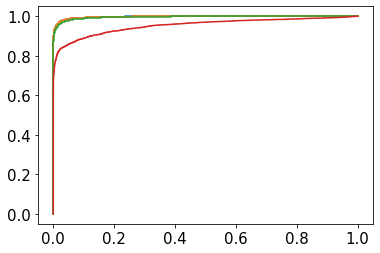

In [34]:
estimate_threshold_temp_scaling(model1, val_loader_cifar10, 8/255, 1/255, 20, [2,5,10,20], "/notebooks/Images/temp_scaling2.pdf", save=True)

# Test detection accuracy

In [42]:
detection_algorithm_PGD(model1, val_loader_cifar10, test_loader_cifar10, 8/255, 1/255, 40, printt=True)

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


TPR (Sensitivity) = 0.854500
FPR = 0.011900
FNR (Specificity) = 0.145500
threshold energy :  -24.404339490156067632


(0.8545, 0.1455, 0.0119)

In [14]:
detection_algorithm_PGD(model1, val_loader_cifar10, test_loader_cifar10, 8/255, 1/255, 40, printt=True)

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


TPR (Sensitivity) = 0.983800
FPR = 0.016700
FNR (Specificity) = 0.016200
threshold energy :  -15.994457053376625897


(0.9838, 0.0162, 0.0167)